In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from time import time

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("darkgrid")

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('statevector_simulator'))

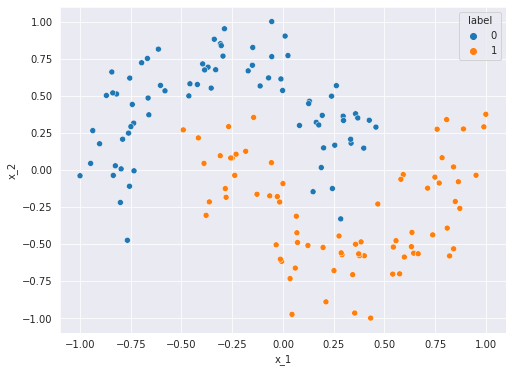

In [2]:
### Moonshape data
X,y = datasets.make_moons(n_samples=150, noise=0.2, random_state=10)

from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

plt.figure(figsize=(8,6))
data_df = pd.DataFrame(dict(x_1=X[:,0], x_2=X[:,1], label=y))
sns.scatterplot('x_1', 'x_2', data=data_df, hue='label')
plt.show()

from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state = 10,test_size=1/5)

### QSVM

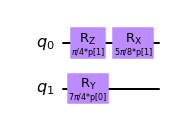

In [3]:
from qiskit.circuit import ParameterVector
p = ParameterVector('p', 2)  

qc = QuantumCircuit(2)

qc.rz((1/4)*np.pi*p[1],0)
qc.rx((5/8)*np.pi*p[1],0)
qc.ry((7/4)*np.pi*p[0],1)

test_kernel = QuantumKernel(feature_map=qc, quantum_instance=quantum_instance,)
qc.draw(output="mpl")

In [4]:
model_t = SVC(kernel=test_kernel.evaluate)
qsvm = model_t.fit(train_x, train_y)
q_score = model_t.score(test_x, test_y)

print(f'Test kernel score: {q_score}')

Test kernel score: 1.0


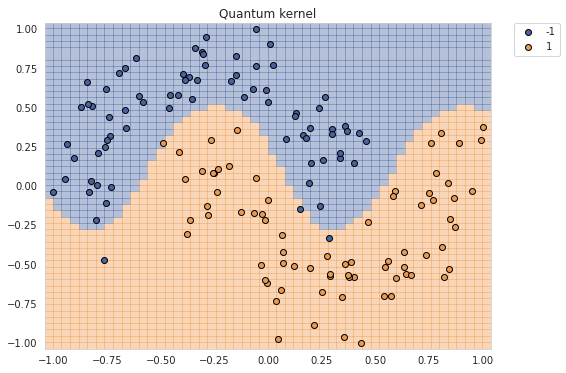

Cost time: 20.857555 s
QSVM test score: 1.0


In [5]:
GRID = 0.04

sns.set_style("whitegrid")

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = train_x[:, 0], train_x[:, 1]

def make_big_meshgrid(x, y, h=GRID): 
    xx, yy = np.meshgrid(np.arange(-1.04, 1.04+GRID, h), np.arange(-1.04, 1.04+GRID, h))
    return xx, yy

bbxx, bbyy = make_big_meshgrid(X0, X1)
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))
meshgrid_time1 = time()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(8,6))
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.4)

plt.scatter(
    X[:, 0][y == 0],
    X[:, 1][y == 0],
    marker="o",
    facecolors="#4863A0",
    edgecolors="k",
    label="-1",)

plt.scatter(
    X[:, 0][y == 1],
    X[:, 1][y == 1],
    marker="o",
    facecolors="#EE9A4D",
    edgecolors="k",
    label="1",)

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Quantum kernel")
plt.show()

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))
print(f'QSVM test score: {q_score}')

### VQC

In [6]:
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.algorithms.optimizers import SPSA
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_y_oh = encoder.fit_transform(train_y.reshape(-1, 1)).toarray()
test_y_oh = encoder.fit_transform(test_y.reshape(-1, 1)).toarray()

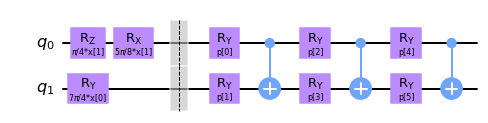

In [7]:
qc_fm = QuantumCircuit(2)
p_fn = ParameterVector("x",2)
qc_fm.rz((1/4)*np.pi*p_fn[1],0)
qc_fm.rx((5/8)*np.pi*p_fn[1],0)
qc_fm.ry((7/4)*np.pi*p_fn[0],1)


qc_az = QuantumCircuit(2)   
p_az = ParameterVector("p",6)
for i in range(2): qc_az.ry(p_az[i],i)
qc_az.cx(0,1)
for i in range(2): qc_az.ry(p_az[i+2],i)
qc_az.cx(0,1)
for i in range(2): qc_az.ry(p_az[i+4],i)
qc_az.cx(0,1)


qc_display = QuantumCircuit(2)
qc_display.append(qc_fm,range(2))
qc_display.barrier()
qc_display.append(qc_az,range(2))
qc_display.decompose().draw(output="mpl")

In [8]:
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)
    
parameters = []
costs = []
evaluations = []

initial_point = np.array([1.0,1.0,1.0,1.0,1.0,1.0])

vqc = VQC(feature_map=qc_fm,
          ansatz=qc_az,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=quantum_instance)

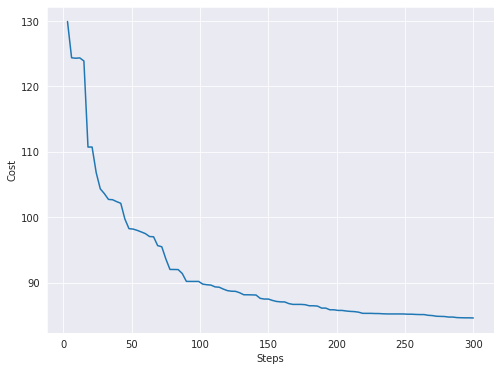

Cost time: 267.402122 s
VQC test score: 0.7666666666666667


In [9]:
sns.set_style("darkgrid")
train_time1 = time()
vqc.fit(train_x, train_y_oh)
train_time2 = time()

v_score = vqc.score(test_x, test_y_oh)

plt.figure(figsize=(8,6))
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

print("Cost time: {:3f} s".format(train_time2-train_time1))
print(f'VQC test score: {v_score}')